### Машинное Обучения

## Домашнее задание №2 - Дерево решений

**Общая информация**

**Срок сдачи:** 23 апреля 2024, 23:59   
**Штраф за опоздание:** -2 балла за каждые 2 дня опоздания

Решений залить в свой github репозиторий.

Используйте данный Ipython Notebook при оформлении домашнего задания.

##  Реализуем дерево решений (3 балла)

Допишите недостающие части дерева решений. Ваша реализация дерева должна работать по точности не хуже DecisionTreeClassifier из sklearn.
Внимание: если Вас не устраивает предложенная структура хранения дерева, Вы без потери баллов можете сделать свой класс MyDecisionTreeClassifier, в котором сами полностью воспроизведете алгоритм дерева решений. Обязательно в нем иметь только функции fit, predict . (Но название класса не менять)

In [189]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


from sklearn.datasets import load_wine
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier

In [190]:
from collections import Counter

class MyDecisionTreeClassifier:
    NON_LEAF_TYPE = 0
    LEAF_TYPE = 1

    def __init__(self, min_samples_split=2, max_depth=5, criterion='gini'):
        """
        criterion -- критерий расщепления. необходимо релизовать три:
        Ошибка классификации, Индекс Джини, Энтропийный критерий
        max_depth -- максимальная глубина дерева
        min_samples_split -- минимальное число объектов в листе, чтобы сделать новый сплит
        """
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.num_class = -1
        # Для последнего задания
        self.feature_importances_ = None
        self.criterion = criterion
        # Структура, которая описывает дерево
        # Представляет словарь, где для  node_id (айдишник узла дерева) храним
        # (тип_узла, айдишник признака сплита, порог сплита) если тип NON_LEAF_TYPE
        # (тип_узла, предсказание класса, вероятность класса) если тип LEAF_TYPE
        # Подразумевается, что у каждого node_id в дереве слева
        # узел с айди 2 * node_id + 1, а справа 2 * node_id + 2
        self.tree = dict()

    def __H_calc(self, y):
        unique, counts = np.unique(y, return_counts = True)
        norm_counts = counts/np.sum(counts)
        if self.criterion == 'gini':
            return np.sum((1-norm_counts)*norm_counts)
        if self.criterion == 'entropy':
            x_nonzero = norm_counts[norm_counts != 0]
            return np.sum(-np.log(x_nonzero)*x_nonzero)


    def __div_samples(self, x, y, feature_id, threshold):
        """
        Разделяет объекты на 2 множества
        x -- матрица объектов
        y -- вектор ответов
        feature_id -- айдишник признака, по которому делаем сплит
        threshold -- порог, по которому делаем сплит
        """

        left_mask = x[:, feature_id] < threshold
        right_mask = ~left_mask
        return x[left_mask], x[right_mask], y[left_mask], y[right_mask]

    def __find_best_split(self, x, y, feature_id):
        n = x.shape[0]
        impurity_best = None
        threshold_best = 0
        feature_importance_best = None

        sorted_x = np.sort(np.unique(x[:, feature_id]))
        thresholds = np.add(sorted_x[:-1], np.diff(sorted_x)/2)
        H_node = self.__H_calc(y)
        for threshold in thresholds:
            _, _, y_left, y_right =  self.__div_samples(x, y, feature_id, threshold)
            H_left  =  self.__H_calc(y_left)
            H_right =  self.__H_calc(y_right)
            impurity = H_left*len(y_left)/n + H_right*len(y_right)/n
            if  impurity_best is None or impurity < impurity_best:
                impurity_best = impurity
                threshold_best = threshold
            #print(f"for {feature_id} imp = {impurity_best}, threshhold = {best_threshold}")

        if impurity_best is None:
            return 0, 2

        return threshold_best, impurity_best

    def __find_threshold(self, x, y):
        """
        Находим оптимальный признак и порог для сплита
        Здесь используемые разные impurity в зависимости от self.criterion
        """

        threshold_best = None
        feature_id_best = None
        impurity_best = None

        for feature_id in range(x.shape[1]):
            threshold, impurity = self.__find_best_split(x, y, feature_id)
            if impurity_best is None or impurity < impurity_best:
                feature_id_best = feature_id
                threshold_best = threshold
                impurity_best = impurity

        self.feature_importances_[0][feature_id_best] += self.__H_calc(y) - impurity_best
        self.feature_importances_[1][feature_id_best] += 1

        return feature_id_best, threshold_best

    def __fit_node(self, x, y, node_id, depth):
        """
        Делаем новый узел в дереве
        Решаем, терминальный он или нет
        Если нет, то строим левый узел  с айди 2 * node_id + 1
        И правый узел с  айди 2 * node_id + 2
        """
        self.tree[node_id] = [0, 0, 0]

        node = self.tree[node_id]
        node[0] = self.__class__.NON_LEAF_TYPE
        if np.all(y == y[0]) or depth == self.max_depth or len(y) <= self.min_samples_split:
            node[0] = self.__class__.LEAF_TYPE
            node[1] = Counter(y).most_common(1)[0][0]
            node[2] = Counter(y).most_common(1)[0][1]/np.size(y)
            return

        feature_id, threshold = self.__find_threshold(x, y)
        x_left, x_right, y_left, y_right = self.__div_samples(x, y, feature_id, threshold)
        self.__fit_node(x_left, y_left, 2*node_id+1, depth+1)
        self.__fit_node(x_right, y_right, 2*node_id+2, depth+1)
        node[1] = feature_id
        node[2] = threshold

    def fit(self, x, y):
        """
        Рекурсивно строим дерево решений
        Начинаем с корня node_id 0
        """
        self.feature_importances_ = np.zeros((2, x.shape[1]))
        self.__fit_node(x, y, 0, 0)


    def __predict_class(self, x, node_id):
        """
        Рекурсивно обходим дерево по всем узлам,
        пока не дойдем до терминального
        """
        node = self.tree[node_id]
        if node[0] == self.__class__.NON_LEAF_TYPE:
            _, feature_id, threshold = node
            if x[feature_id] < threshold:
                return self.__predict_class(x, 2 * node_id + 1)
            else:
                return self.__predict_class(x, 2 * node_id + 2)
        else:

            return node[1]

    def predict(self, X):
        """
        Вызывает predict для всех объектов из матрицы X
        """
        return np.array([self.__predict_class(x, 0) for x in X])

    def fit_predict(self, x_train, y_train, predicted_x):
        self.fit(x_train, y_train)
        return self.predict(predicted_x)

    def get_feature_importance(self, importance_type = 'gain'):
        """
        Возвращает важность признаков
        """
        gains = self.feature_importances_[0]
        splits = self.feature_importances_[1]
        if importance_type == 'gain':
            sorted_indices = np.argsort(gains)[::-1]
            importances = gains
        else:
            sorted_indices = np.argsort(splits)[::-1]
            importances = splits
        return sorted_indices, importances

In [191]:
my_clf = MyDecisionTreeClassifier(min_samples_split=2)
clf = DecisionTreeClassifier(min_samples_split=2)

In [192]:
wine = load_wine()
X_train, X_test, y_train, y_test = train_test_split(wine.data, wine.target, test_size=0.1, stratify=wine.target)

In [193]:
my_clf.fit(X_train, y_train)
clf.fit(X_train, y_train)

DecisionTreeClassifier()

In [194]:
my_clf.predict(X_test)

array([1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 0, 2, 2, 0, 1, 2, 1, 0])

In [195]:
clf.predict(X_test)

array([1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 0, 2, 2, 0, 1, 2, 1, 0])

In [196]:
accuracy_score(y_pred=clf.predict(X_test), y_true=y_test)


0.8333333333333334

In [197]:
accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test)

0.8333333333333334

In [198]:
my_clf.get_feature_importance("splits")

(array([ 2, 12,  9,  6,  0, 11, 10,  8,  7,  5,  4,  3,  1]),
 array([1., 0., 2., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1.]))

Совет: Проверьте, что ваша реализация корректно работает с признаками в которых встречаются повторы.
И подумайте, какие еще граничные случаи могут быть.
Например, проверьте, что на таком примере ваша модель корректно работает:

In [199]:
X = np.array([[1] * 10, [0, 1, 2, 5, 6, 3, 4, 7, 8, 9]]).T
y = np.array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1])
for depth in range(1, 5):
    my_clf = MyDecisionTreeClassifier(max_depth=depth)
    my_clf.fit(X, y)
    print("DEPTH:", depth, "\n\t\tTree:", my_clf.tree, my_clf.predict(X))

DEPTH: 1 
		Tree: {0: [0, 1, 2.5], 1: [1, 0, 1.0], 2: [1, 1, 0.7142857142857143]} [0 0 0 1 1 1 1 1 1 1]
DEPTH: 2 
		Tree: {0: [0, 1, 2.5], 1: [1, 0, 1.0], 2: [0, 1, 6.5], 5: [1, 0, 0.5], 6: [1, 1, 1.0]} [0 0 0 0 0 0 0 1 1 1]
DEPTH: 3 
		Tree: {0: [0, 1, 2.5], 1: [1, 0, 1.0], 2: [0, 1, 6.5], 5: [0, 1, 4.5], 11: [1, 1, 1.0], 12: [1, 0, 1.0], 6: [1, 1, 1.0]} [0 0 0 0 0 1 1 1 1 1]
DEPTH: 4 
		Tree: {0: [0, 1, 2.5], 1: [1, 0, 1.0], 2: [0, 1, 6.5], 5: [0, 1, 4.5], 11: [1, 1, 1.0], 12: [1, 0, 1.0], 6: [1, 1, 1.0]} [0 0 0 0 0 1 1 1 1 1]


## Ускоряем дерево решений (2 балла)
Добиться скорости работы на fit не медленнее чем в 10 раз sklearn на данных wine.
Для этого используем numpy.

In [200]:
%time clf.fit(X_train, y_train)

CPU times: user 2.97 ms, sys: 0 ns, total: 2.97 ms
Wall time: 3.12 ms


DecisionTreeClassifier()

In [201]:
%time my_clf.fit(X_train, y_train)

CPU times: user 341 ms, sys: 5.14 ms, total: 346 ms
Wall time: 360 ms


## Боевое применение (3 балла)

На практике Вы познакомились с датасетом Speed Dating Data. В нем каждая пара в быстрых свиданиях характеризуется определенным набором признаков. Задача -- предсказать, произойдет ли матч пары (колонка match).

Данные и описания колонок во вложениях.

Пример работы с датасетом можете найти в практике пункт 2
https://github.com/VVVikulin/ml1.sphere/blob/master/2019-09/lecture_06/pract-trees.ipynb

Либо воспользоваться функцией:

In [202]:
df = pd.read_csv("Speed_Dating_Data.csv", encoding='latin1')
df

,iid,id,gender,idg,condtn,wave,round,position,positin1,order,...,attr3_3,sinc3_3,intel3_3,fun3_3,amb3_3,attr5_3,sinc5_3,intel5_3,fun5_3,amb5_3
0,1,1.0,0,1,1,1,10,7,NaN,4,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
1,1,1.0,0,1,1,1,10,7,NaN,3,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
2,1,1.0,0,1,1,1,10,7,NaN,10,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
3,1,1.0,0,1,1,1,10,7,NaN,5,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
4,1,1.0,0,1,1,1,10,7,NaN,7,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8373,552,22.0,1,44,2,21,22,14,10.0,5,...,8.0,5.0,7.0,6.0,7.0,9.0,5.0,9.0,5.0,6.0
8374,552,22.0,1,44,2,21,22,13,10.0,4,...,8.0,5.0,7.0,6.0,7.0,9.0,5.0,9.0,5.0,6.0
8375,552,22.0,1,44,2,21,22,19,10.0,10,...,8.0,5.0,7.0,6.0,7.0,9.0,5.0,9.0,5.0,6.0
8376,552,22.0,1,44,2,21,22,3,10.0,16,...,8.0,5.0,7.0,6.0,7.0,9.0,5.0,9.0,5.0,6.0


In [203]:
def preprocess_spd_data(df):
    df = df.iloc[:, :97]

    to_drop = [
        'id', 'idg', 'condtn', 'round', 'position', 'positin1', 'order', 'partner',
        'age_o', 'race_o', 'pf_o_att', 'pf_o_sin', 'pf_o_int', 'pf_o_fun', 'pf_o_amb', 'pf_o_sha',
        'dec_o', 'attr_o', 'sinc_o', 'intel_o', 'fun_o', 'amb_o', 'shar_o', 'like_o', 'prob_o','met_o',
        'field', 'undergra', 'from', 'zipcode', 'income', 'career', 'sports', 'tvsports', 'exercise',
        'dining', 'museums', 'art', 'hiking', 'gaming', 'clubbing', 'reading', 'tv', 'theater', 'movies',
        'concerts', 'music', 'shopping', 'yoga', 'expnum',
        'mn_sat', 'tuition'
    ]

    df = df.drop(to_drop, axis=1)
    df = df.dropna(subset=['age', 'imprelig', 'imprace', 'date'])

    df.loc[:, 'field_cd'] = df.loc[:, 'field_cd'].fillna(19)
    df.loc[:, 'career_c'] = df.loc[:, 'career_c'].fillna(18)

    # attr1 processing
    df.loc[:, 'temp_totalsum'] = df.loc[:, ['attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1',
                                            'amb1_1', 'shar1_1']].sum(axis=1)
    df.loc[:, ['attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 'amb1_1', 'shar1_1']] =\
    (df.loc[:, ['attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 'amb1_1', 'shar1_1']].T /
     df.loc[:, 'temp_totalsum'].T).T * 100

    # attr2 processing
    df.loc[:, 'temp_totalsum'] = df.loc[:, ['attr2_1', 'sinc2_1', 'intel2_1', 'fun2_1',
                                            'amb2_1', 'shar2_1']].sum(axis=1)
    df.loc[:, ['attr2_1', 'sinc2_1', 'intel2_1', 'fun2_1', 'amb2_1', 'shar2_1']] =\
    (df.loc[:, ['attr2_1', 'sinc2_1', 'intel2_1', 'fun2_1', 'amb2_1', 'shar2_1']].T /
     df.loc[:, 'temp_totalsum'].T).T * 100
    df = df.drop(['temp_totalsum'], axis=1)

    for i in [4, 5]:
        feat = ['attr{}_1'.format(i), 'sinc{}_1'.format(i),
                'intel{}_1'.format(i), 'fun{}_1'.format(i),
                'amb{}_1'.format(i), 'shar{}_1'.format(i)]

        if i != 4:
            feat.remove('shar{}_1'.format(i))

        df = df.drop(feat, axis=1)

    df = df.drop(['wave'], axis=1)
    df = df.dropna()
    return df

Скачайте датасет, обработайте данные, как показано на семинаре или своим собственным способом. Обучите дерево классифкации. В качестве таргета возьмите колонку 'match'. Постарайтесь хорошо обработать признаки, чтобы выбить максимальную точность. Если точность будет близка к случайному гаданию, задание не будет защитано. В качестве метрики можно взять roc-auc.


In [204]:
df_new = preprocess_spd_data(df)
df_new

,iid,gender,pid,match,int_corr,samerace,age,field_cd,race,imprace,...,sinc2_1,intel2_1,fun2_1,amb2_1,shar2_1,attr3_1,sinc3_1,fun3_1,intel3_1,amb3_1
0,1,0,11.0,0,0.14,0,21.0,1.0,4.0,2.0,...,20.0,15.0,20.0,5.0,5.0,6.0,8.0,8.0,8.0,7.0
1,1,0,12.0,0,0.54,0,21.0,1.0,4.0,2.0,...,20.0,15.0,20.0,5.0,5.0,6.0,8.0,8.0,8.0,7.0
2,1,0,13.0,1,0.16,1,21.0,1.0,4.0,2.0,...,20.0,15.0,20.0,5.0,5.0,6.0,8.0,8.0,8.0,7.0
3,1,0,14.0,1,0.61,0,21.0,1.0,4.0,2.0,...,20.0,15.0,20.0,5.0,5.0,6.0,8.0,8.0,8.0,7.0
4,1,0,15.0,1,0.21,0,21.0,1.0,4.0,2.0,...,20.0,15.0,20.0,5.0,5.0,6.0,8.0,8.0,8.0,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8373,552,1,526.0,0,0.64,0,25.0,18.0,2.0,1.0,...,0.0,0.0,30.0,0.0,20.0,8.0,7.0,6.0,7.0,7.0
8374,552,1,527.0,0,0.71,0,25.0,18.0,2.0,1.0,...,0.0,0.0,30.0,0.0,20.0,8.0,7.0,6.0,7.0,7.0
8375,552,1,528.0,0,-0.46,0,25.0,18.0,2.0,1.0,...,0.0,0.0,30.0,0.0,20.0,8.0,7.0,6.0,7.0,7.0
8376,552,1,529.0,0,0.62,0,25.0,18.0,2.0,1.0,...,0.0,0.0,30.0,0.0,20.0,8.0,7.0,6.0,7.0,7.0


In [205]:
df_new.isna().sum().sum()

0

In [206]:
y = df_new['match']
X = df_new.drop('match', axis = 1)

In [207]:
y = np.array(y)
y

array([0, 0, 1, ..., 0, 0, 0])

In [208]:
X

,iid,gender,pid,int_corr,samerace,age,field_cd,race,imprace,imprelig,...,sinc2_1,intel2_1,fun2_1,amb2_1,shar2_1,attr3_1,sinc3_1,fun3_1,intel3_1,amb3_1
0,1,0,11.0,0.14,0,21.0,1.0,4.0,2.0,4.0,...,20.0,15.0,20.0,5.0,5.0,6.0,8.0,8.0,8.0,7.0
1,1,0,12.0,0.54,0,21.0,1.0,4.0,2.0,4.0,...,20.0,15.0,20.0,5.0,5.0,6.0,8.0,8.0,8.0,7.0
2,1,0,13.0,0.16,1,21.0,1.0,4.0,2.0,4.0,...,20.0,15.0,20.0,5.0,5.0,6.0,8.0,8.0,8.0,7.0
3,1,0,14.0,0.61,0,21.0,1.0,4.0,2.0,4.0,...,20.0,15.0,20.0,5.0,5.0,6.0,8.0,8.0,8.0,7.0
4,1,0,15.0,0.21,0,21.0,1.0,4.0,2.0,4.0,...,20.0,15.0,20.0,5.0,5.0,6.0,8.0,8.0,8.0,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8373,552,1,526.0,0.64,0,25.0,18.0,2.0,1.0,1.0,...,0.0,0.0,30.0,0.0,20.0,8.0,7.0,6.0,7.0,7.0
8374,552,1,527.0,0.71,0,25.0,18.0,2.0,1.0,1.0,...,0.0,0.0,30.0,0.0,20.0,8.0,7.0,6.0,7.0,7.0
8375,552,1,528.0,-0.46,0,25.0,18.0,2.0,1.0,1.0,...,0.0,0.0,30.0,0.0,20.0,8.0,7.0,6.0,7.0,7.0
8376,552,1,529.0,0.62,0,25.0,18.0,2.0,1.0,1.0,...,0.0,0.0,30.0,0.0,20.0,8.0,7.0,6.0,7.0,7.0


Разбейте датасет на трейн и валидацию. Подберите на валидации оптимальный критерий  информативности.
Постройте графики зависимости точности на валидации и трейне от глубины дерева, от минимального числа объектов для сплита. (Т.е должно быть 2 графика, на каждой должны быть 2 кривые - для трейна и валидации)
Какой максимальной точности удалось достигнуть?

In [209]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

In [327]:
for criterion in ['entropy', 'gini']:
    my_clf = MyDecisionTreeClassifier(criterion = criterion)
    my_clf.fit(np.array(X_train), np.array(y_train))
    y_pred_val = my_clf.predict(np.array(X_val))
    y_pred_train = my_clf.predict(np.array(X_train))
    acc_val = accuracy_score(y_val, y_pred_val)
    acc_train = accuracy_score(y_train, y_pred_train)
    print(f"with {criterion} acc_val = {acc_val}")
    print(f"with {criterion} acc_train = {acc_train}")

with entropy acc_val = 0.8338815789473685
with entropy acc_train = 0.8416784203102962
with gini acc_val = 0.8273026315789473
with gini acc_train = 0.8418547249647391


In [341]:
acc_val_split = []
acc_train_split = []

for min_samples_split in range(1, 50, 6):
    my_clf = MyDecisionTreeClassifier(criterion = 'entropy', min_samples_split = min_samples_split)
    my_clf.fit(np.array(X_train), np.array(y_train))
    y_pred_val = my_clf.predict(np.array(X_val))
    y_pred_train = my_clf.predict(np.array(X_train))
    acc_val_split.append(accuracy_score(y_val, y_pred_val))
    acc_train_split.append(accuracy_score(y_train, y_pred_train))

0.8359375


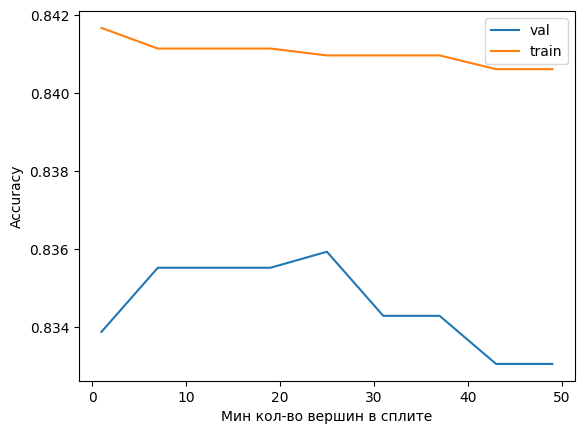

In [349]:
plt.plot(range(1, 50, 6), acc_val_split, label = "val")
plt.plot(range(1, 50, 6), acc_train_split, label = "train")
plt.xlabel("Мин кол-во вершин в сплите")
plt.ylabel("Accuracy")
plt.legend()
print(max(acc_val_split))

In [347]:
acc_val_depth = []
acc_train_depth = []

for max_depth in range(1, 11):
    my_clf = MyDecisionTreeClassifier(criterion = 'entropy', max_depth = max_depth)
    my_clf.fit(np.array(X_train), np.array(y_train))
    y_pred_val = my_clf.predict(np.array(X_val))
    y_pred_train = my_clf.predict(np.array(X_train))
    acc_val_depth.append(accuracy_score(y_val, y_pred_val))
    acc_train_depth.append(accuracy_score(y_train, y_pred_train))

0.8351151315789473


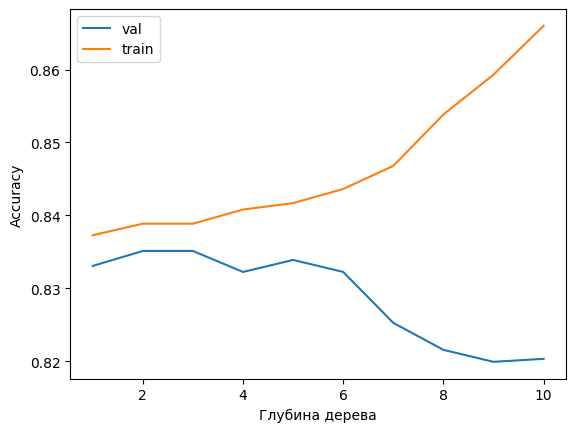

In [350]:
plt.plot(range(1, 11), acc_val_depth, label = "val")
plt.plot(range(1, 11), acc_train_depth, label = "train")
plt.xlabel("Глубина дерева")
plt.ylabel("Accuracy")
plt.legend()
print(max(acc_val_depth))

**ИТОГО**: Максимальная точность, которой получилось добиться ~ 83.6% при тюнинге только одного из параметров

При увеличении глубины сначала качество растет, а потом падает. Это связано с тем, что сначала решающий пень плохо разделяет наше пространство из-за слабости модели как на тестовой так и на валидационной выборке. После увеличения глубины, дерево переобучается под тестовые данные, теряет способность к генерализации данных, поэтому качество на валидации падает.

Известным фактом является то, что деревья решений сильно переобучаются при увеличении глубины и просто запоминают трейн.
Замечаете ли вы такой эффект судя по графикам? Что при этом происходит с качеством на валидации?

## Находим самые важные признаки (2 балла)



По построенному дереву  легко понять, какие признаки лучше всего помогли решить задачу. Часто это бывает нужно  не только  для сокращения размерности в данных, но и для лучшего понимания прикладной задачи. Например, Вы хотите понять, какие признаки стоит еще конструировать -- для этого нужно понимать, какие из текущих лучше всего работают в дереве.

Самый простой метод -- посчитать число сплитов, где использовался данные признак. Это не лучший вариант, так как по признаку который принимает всего 2 значения, но который почти точно разделяет выборку, число сплитов будет очень 1, но при этом признак сам очень хороший.
В этом задании предлагается для каждого признака считать суммарный gain (в лекции обозначено как Q) при использовании этого признака в сплите. Тогда даже у очень хороших признаков с маленьким число сплитов это значение должно быть довольно высоким.  

Реализовать это довольно просто: создаете словарь номер фичи : суммарный гейн и добавляете в нужную фичу каждый раз, когда используете ее при построении дерева.

Добавьте функционал, который определяет значения feature importance. Обучите дерево на датасете Speed Dating Data.
Выведите 10 главных фичей по важности.

In [210]:
my_clf = MyDecisionTreeClassifier(criterion = "entropy")
my_clf.fit(np.array(X_train), np.array(y_train))

sorted_indices = my_clf.get_feature_importance("gain")[0]


In [211]:
features = np.array(list(X_train.columns))[sorted_indices][:10]
features

array(['iid', 'int_corr', 'pid', 'race', 'exphappy', 'attr1_1', 'imprace',
       'amb1_1', 'imprelig', 'sinc1_1'], dtype='<U8')

In [239]:
importances = my_clf.get_feature_importance("gains")[1][sorted_indices][:10]
importances

array([5., 4., 5., 1., 2., 1., 1., 1., 1., 1.])

In [240]:
data = pd.DataFrame(np.stack((features, importances)).T)

In [241]:
data = data.rename(columns = {0:"feature_name", 1:"importance"})
data

,feature_name,importance
0,iid,5.0
1,int_corr,4.0
2,pid,5.0
3,race,1.0
4,exphappy,2.0
5,attr1_1,1.0
6,imprace,1.0
7,amb1_1,1.0
8,imprelig,1.0
9,sinc1_1,1.0


<BarContainer object of 10 artists>

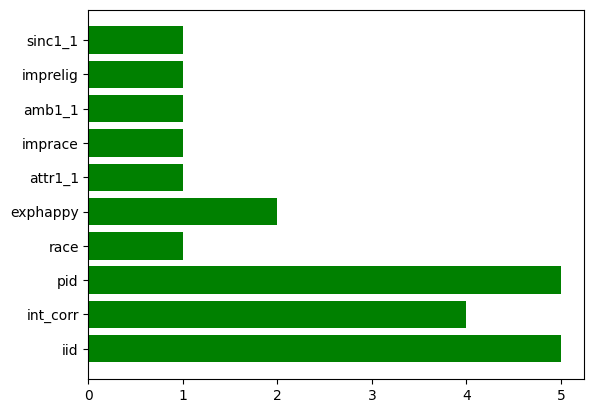

In [242]:
plt.barh(features,importances, color = "green")

## Фидбек (бесценно)

Оптимизации для обучения деревьев (гистограммный метод) или хаки для бинарной классификации в деревьях было бы интересно послушать.

### Ваш ответ здесь

* Здесь Вы можете оставить отзыв о этой домашней работе или о всем курсе.

### ВАШ ОТЗЫВ ЗДЕСЬ



Очень нравится делать домашки, они интересные и прокачивают не хуже лаб из вуза. По курсу тоже претензий нет, почти нет душной математики - это плюс и много новой полезной инфы - это тоже плюс